<a href="https://colab.research.google.com/github/nmoisseeva/lahaina/blob/main/fire_progression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#October 20, 2024
#Script plots fire progression from digitized Appx in https://fsri.org/research-update/lahaina-fire-comprehensive-timeline-report-released-attorney-general-hawaii
#Compares to wrf-fire output



In [2]:
!pip install Cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 80.9 MB/s eta 0:00:00


In [3]:
!pip install netCDF4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.4 MB/s eta 0:00:00


In [6]:
import shapefile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
import netCDF4 as nc

import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,
#                  cartopy_xlim, cartopy_ylim)
import os

In [7]:
#### INPUTS ####

#set paths
# wrfrst_path = '/content/drive/MyDrive/data/lahaina/wrfout_d03_2023-08-09_standard'

wrfrst_path = '/content/drive/MyDrive/data/lahaina/wrfout_d03_2023-08-09_18Z07'
wrfrst_path_pattern = '/content/drive/MyDrive/data/lahaina/wrfrst_d03_2023-08-10_'
# wrfrst2_path = '/content/drive/MyDrive/data/lahaina/wrfrst_d03_2023-08-10_0Z08'
# wrfrst3_path = '/content/drive/MyDrive/data/lahaina/wrfrst_d03_2023-08-10_12Z08'


wrfrst_nifc_path = '/content/drive/MyDrive/data/lahaina/wrfrst_d03'


fig_path = '/content/drive/MyDrive/colab/lahaina/figs/'
shp_file = '/content/drive/MyDrive/data/lahaina/fire_perimeters/fsri_perim_extr.shp'
shp_file_nifc = '/content/drive/MyDrive/data/lahaina/fire_perimeters/Perimeters.shp'

csv_file = '/content/drive/MyDrive/data/lahaina/fire_perimeters/digitized_fire_progression.csv'

# ignition_start =  46500    #match the settings from namelist.input (in seconds)
# ignition_start =  111300    #18:00 07-08-2023 start

rst_tags = ['0Z08','12Z08']
ign_start = [111300, 89900, 46500]
# ignition_start =  89900

In [8]:
#load fire perimeters
perim = shapefile.Reader(shp_file).shapeRecord(0)
coords = perim.shape.__geo_interface__['coordinates']
polygons = []
for poly in coords:
  polygons.append(Polygon(np.squeeze(poly)))

In [9]:
#load WFIGSG perimeters (no good)
perim_nifc = shapefile.Reader(shp_file_nifc).shapeRecord(0)
coords_nifc = perim_nifc.shape.__geo_interface__['coordinates']
polygons_nifc = []
for poly in coords_nifc:
  polygons_nifc.append(Polygon(np.squeeze(poly)))


In [33]:
#load the very first wrfdata and get needed vars
wrfrst = nc.Dataset(wrfrst_path, 'r')
flats = wrfrst.variables['FXLAT'][-1]
flons = wrfrst.variables['FXLONG'][-1]
tign = wrfrst.variables['TIGN_G'][-1]
u = wrfrst.variables['U10'][-1]
xlats = wrfrst.variables['XLAT'][-1]
xlons = wrfrst.variables['XLONG'][-1]
fuel = wrfrst.variables['NFUEL_CAT'][-1]

In [34]:
#get hours since ignition
ti_hst = pd.to_datetime('2023-08-08 14:55:00')
tign[tign==0] = np.nan
tign_min = (tign - ign_start[0])/3600

In [12]:
# ign_array = []
ign_array = [tign_min.data]
for iRun, run in enumerate(rst_tags):
  print(f'...opening: {run}')
  wrfrst_file = wrfrst_path_pattern + run
  rstfile = nc.Dataset(wrfrst_file, 'r')
  tign_rst = rstfile.variables['TIGN_G'][-1]
  tign_rst[tign_rst==0] = np.nan
  print(f'..... ignition: {ign_start[iRun+1]}')
  tign_min_rst = (tign_rst - ign_start[iRun+1])/3600
  ign_array.append(tign_min_rst)
  # tign_min.append(tign_min_rst)


...opening: 0Z08
..... ignition: 89900
...opening: 12Z08
..... ignition: 46500


In [125]:
csv = pd.read_csv(csv_file, skipinitialspace=True)
csv.Datetime = pd.to_datetime(csv.Date + ' ' + csv.Time, format='%Y-%m-%d %H:%M')
csv['tdelta'] = csv.Datetime - ti_hst
csv['tdelta_h'] = csv.tdelta.dt.total_seconds() / 3600
# csv.plot.scatter(x='Lon', y='Lat', c='tdelta_min', cmap='viridis')

<ipython-input-125-4bb8d7ed9dbc>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  csv.Datetime = pd.to_datetime(csv.Date + ' ' + csv.Time, format='%Y-%m-%d %H:%M')


In [18]:
from scipy.spatial import cKDTree
import numpy as np

# Assuming 'flats', 'flons', and 'csv' are defined from the previous code

# Create a cKDTree from the WRF data coordinates
tree = cKDTree(list(zip(flats.flatten(), flons.flatten())))

In [126]:
# Function to find the closest point
def find_closest_point(lat, lon):
    distance, index = tree.query([lat, lon])
    return ign_array[iR].flatten()[index]

for iR in range(len(ign_array)):
  col_tag = f'rst{iR}'
  csv[col_tag] = csv.apply(lambda row: pd.Series(find_closest_point(row['Lat'], row['Lon'])), axis=1)
# ign_pairs = np.array(ign_pairs).squeeze()

In [127]:
csv

,Lat,Lon,Date,Time,tdelta,tdelta_h,rst0,rst1,rst2
0,20.883860,-156.664016,2023-08-08,14:55,0 days 00:00:00,0.000000,0.357498,0.357498,0.357497
1,20.884342,-156.662554,2023-08-08,14:58,0 days 00:03:00,0.050000,0.534859,0.534844,0.534860
2,20.884018,-156.664149,2023-08-08,15:00,0 days 00:05:00,0.083333,0.418843,0.418843,0.418843
3,20.883570,-156.665079,2023-08-08,15:05,0 days 00:10:00,0.166667,23.083511,23.027956,23.083511
4,20.884765,-156.663035,2023-08-08,15:06,0 days 00:11:00,0.183333,0.506651,0.506682,0.506650
...,...,...,...,...,...,...,...,...,...
220,20.899615,-156.673864,2023-08-09,5:35,0 days 14:40:00,14.666667,7.077739,5.792743,6.260478
221,20.884951,-156.674365,2023-08-09,5:35,0 days 14:40:00,14.666667,2.176085,2.229436,2.741214
222,20.905052,-156.684495,2023-08-09,5:39,0 days 14:44:00,14.733333,23.083511,23.027956,23.083511
223,20.884951,-156.674365,2023-08-09,5:59,0 days 15:04:00,15.066667,2.176085,2.229436,2.741214


In [119]:
# prompt: calculate variance between tdelta_h and rst0, rst1 and rst2

filtered_csv = csv[csv['18Z07'] <= 20]


# Calculate the variance between 'tdelta_h' and 'rst0', 'rst1', and 'rst2'
variance_rst0 = np.var(filtered_csv['tdelta_h'] - filtered_csv['rst0'])
variance_rst1 = np.var(filtered_csv['tdelta_h'] - filtered_csv['rst1'])
variance_rst2 = np.var(filtered_csv['tdelta_h'] - filtered_csv['rst2'])



print(f"Variance between tdelta_h and rst0: {variance_rst0}")
print(f"Variance between tdelta_h and rst1: {variance_rst1}")
print(f"Variance between tdelta_h and rst2: {variance_rst2}")

Variance between tdelta_h and rst0: 8.555799294270704
Variance between tdelta_h and rst1: 6.418148130979621
Variance between tdelta_h and rst2: 10.660566399458261


<ipython-input-130-b50083d9a40e>:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(filtered_csv['tdelta_h'] - filtered_csv[col_tag], positions=[iR + 1], labels=[col_tag], notch='True')
<ipython-input-130-b50083d9a40e>:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(filtered_csv['tdelta_h'] - filtered_csv[col_tag], positions=[iR + 1], labels=[col_tag], notch='True')
<ipython-input-130-b50083d9a40e>:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(filtered_csv['tdelta_h'] - filtered_csv[col_tag], positions=[iR + 1], labels=[col_tag], notch='True')


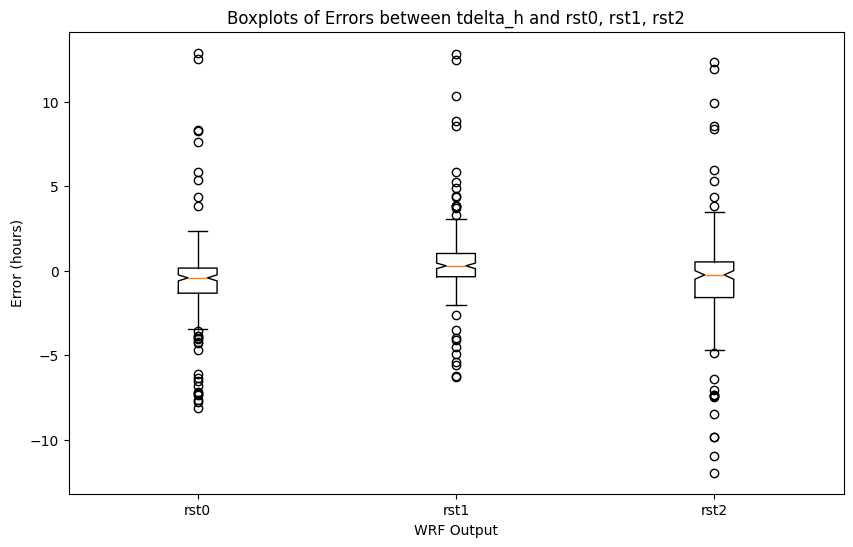

In [130]:
# prompt: create boxplots of errors between filtered_csv['tdelta_h'] and filtered_csv['rst0'], filtered_csv['rst1'], and filtered_csv['rst2']

import matplotlib.pyplot as plt

# Create boxplots of errors
plt.figure(figsize=(10, 6))

for iR in range(len(ign_array)):
  col_tag = f'rst{iR}'
  plt.boxplot(filtered_csv['tdelta_h'] - filtered_csv[col_tag], positions=[iR + 1], labels=[col_tag], notch='True')
# Error between tdelta_h and rst0



plt.title('Boxplots of Errors between tdelta_h and rst0, rst1, rst2')
plt.xlabel('WRF Output')
plt.ylabel('Error (hours)')
plt.show()

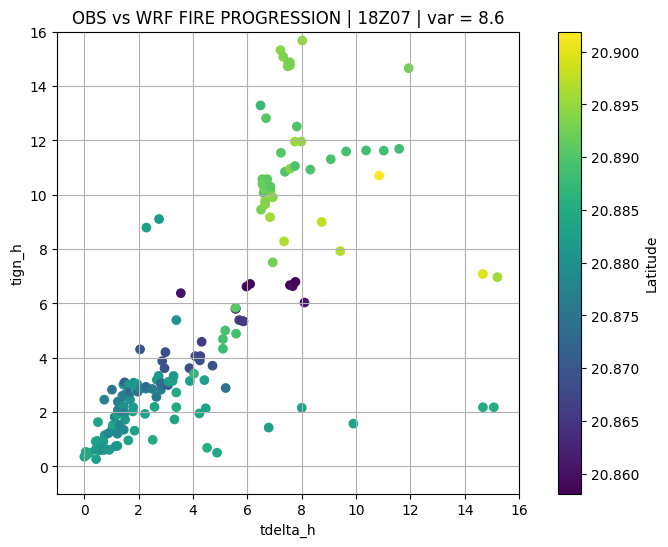

In [145]:
# prompt: create scatter plot for tdelta_h vs tign_h from csv ecluding points where tign_h >20


# Filter out points where tign_h > 20
filtered_csv = csv[csv['rst0'] <= 20]

var_control = np.var(filtered_csv['tdelta_h'] - filtered_csv['rst0'])

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_csv['tdelta_h'], filtered_csv['rst0'], c=filtered_csv['Lat'])
ax = plt.gca()
ax.set(aspect='equal', xlabel = 'tdelta_h', ylabel = 'wrf_h', xlim=[-1,16], ylim=[-1,16])
plt.title(f'OBS vs WRF FIRE PROGRESSION | 18Z07 | var = {var_control:.1f}')
plt.ylabel('tign_h')
plt.colorbar(label='Latitude')
plt.grid(True)
plt.show()

In [14]:
import matplotlib as mpl
from matplotlib import rc
rc('text', usetex=False)
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
mpl.rcParams['figure.dpi'] = 200

In [15]:
#set up google tiles - CHECK THIS IS OK TO USE!
from cartopy.io.img_tiles import GoogleTiles
import cartopy.crs as ccrs

class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)
        return url

In [60]:
ign_var = np.var(ign_array,0)
ign_std = np.std(ign_array,0)

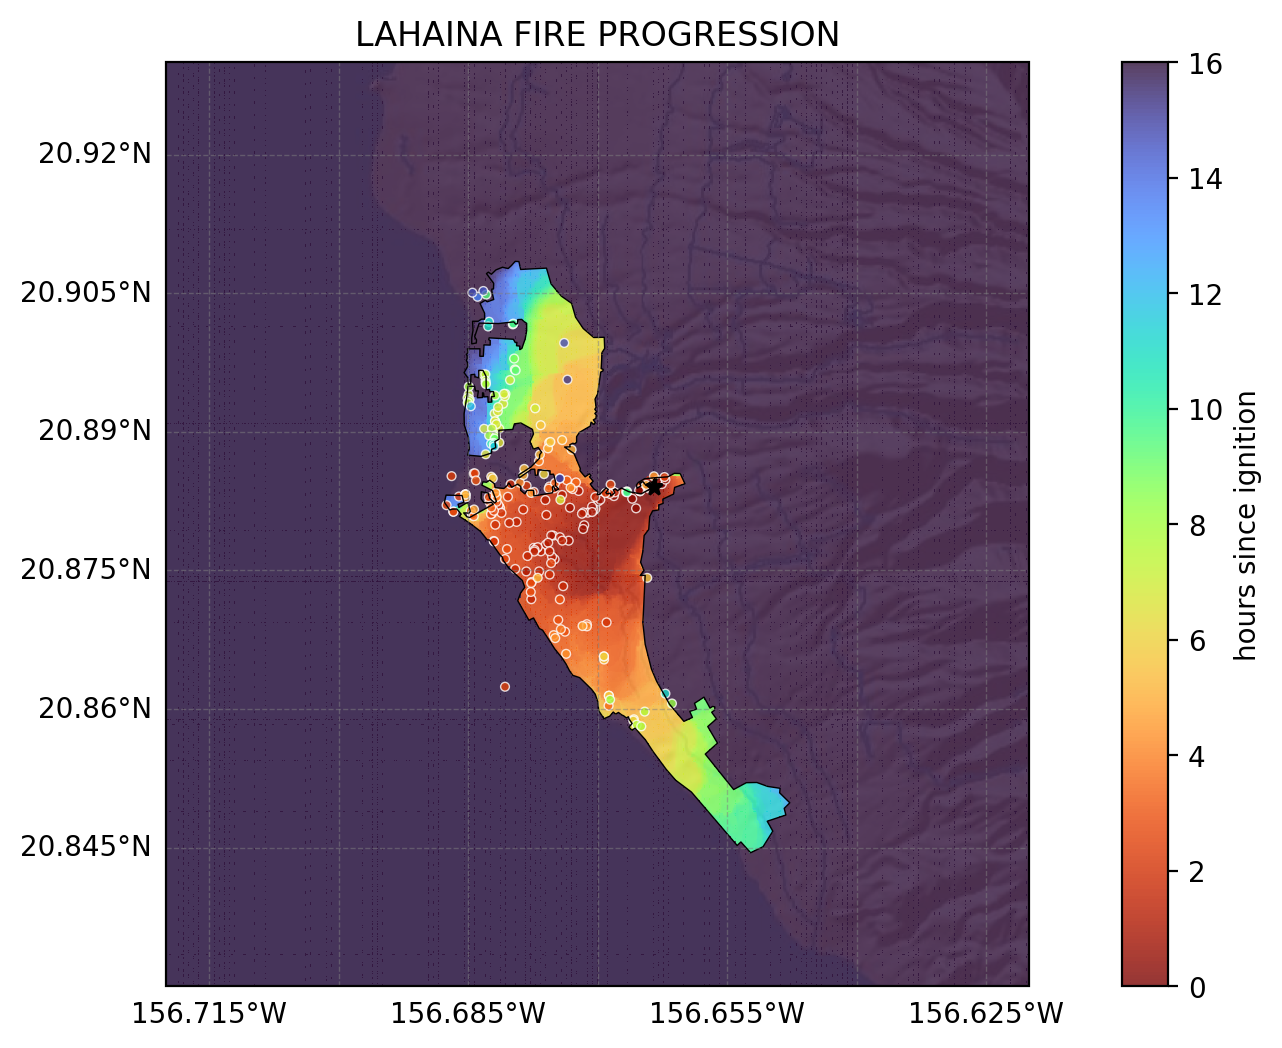

In [29]:
# Create a figure
fig = plt.figure(figsize=(12,6))

# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=ShadedReliefESRI().crs)
ax.set_extent([-156.72,-156.62, 20.83, 20.93])
ax.add_image(ShadedReliefESRI(), 13)

# ax = plt.axes(projection=crs.PlateCarree())
# plt.pcolormesh(flons, flats, tign_min, cmap='turbo_r', transform=crs.PlateCarree(),vmin = 0, vmax = 16, alpha=0.8)
plt.pcolormesh(flons, flats, ign_array[1], cmap='turbo_r', transform=crs.PlateCarree(),vmin = 0, vmax = 16, alpha=0.8)

ax = plt.gca()
ax.add_geometries(polygons, crs=crs.PlateCarree(), edgecolor='black', alpha=1, facecolor='none', linewidth=0.5)

plt.scatter(csv.Lon, csv.Lat, c=csv.tdelta_h, cmap='turbo_r',vmin=0, vmax=16,edgecolors='white', s=10, \
            linewidth=0.5, transform=crs.PlateCarree(),alpha=0.8)
# plt.gca().set(xlim = [-156.72,-156.62],ylim = [20.83,20.93])
ax.plot(-156.663453,20.884069, marker="*", color="black", transform=crs.PlateCarree())
plt.colorbar(label='hours since ignition')
plt.title('LAHAINA FIRE PROGRESSION')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
# plt.savefig(fig_path + 'fire_progression_fsri_18Z07.png', dpi=300)


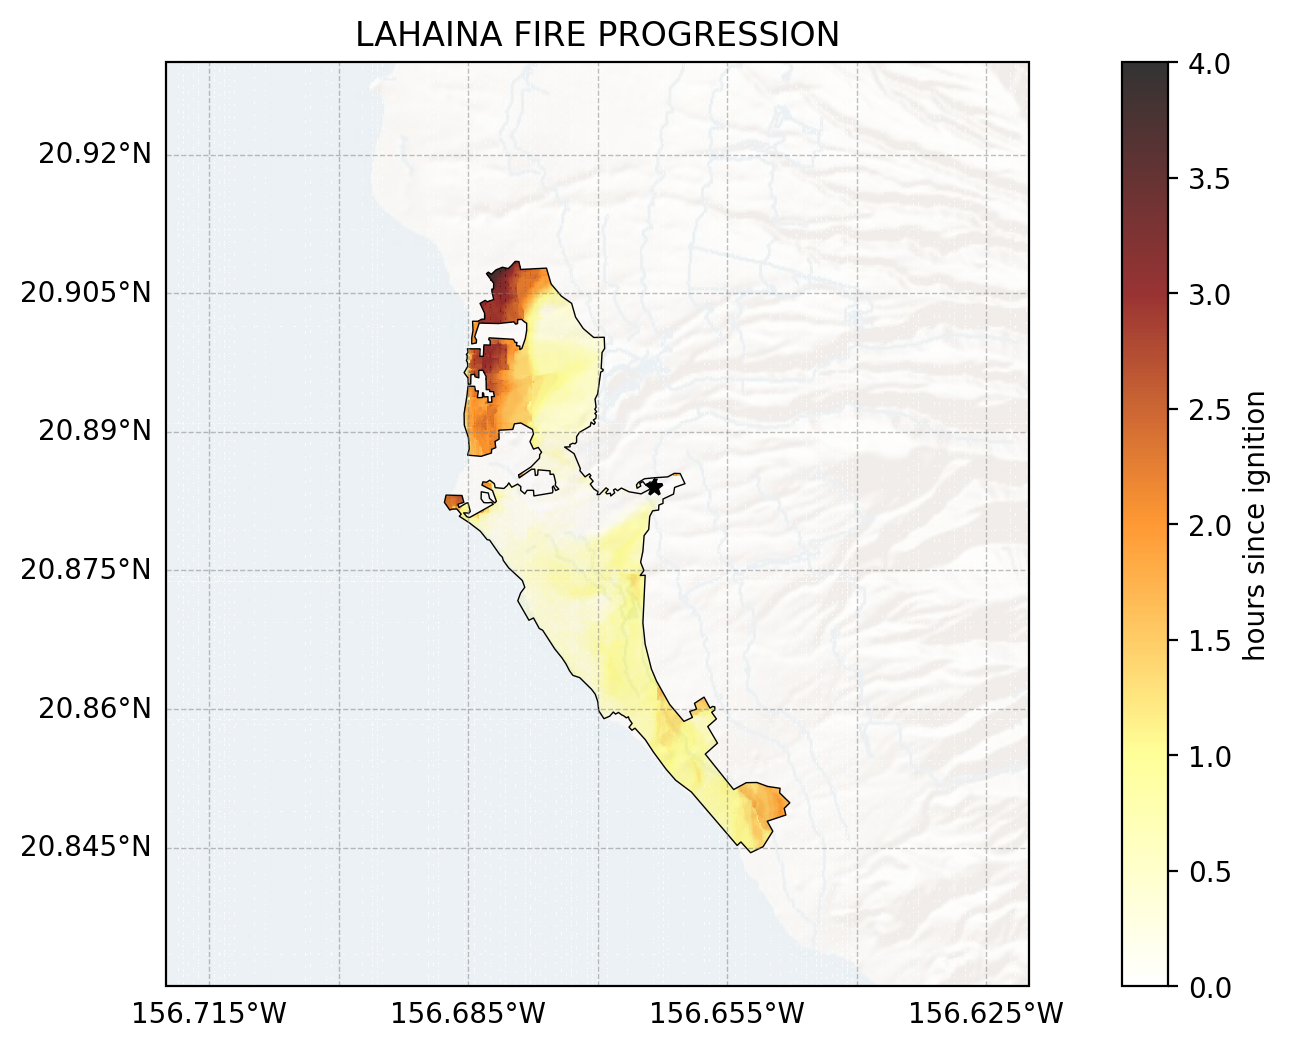

In [63]:
# Create a figure (difference between the sets)
fig = plt.figure(figsize=(12,6))

# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=ShadedReliefESRI().crs)
ax.set_extent([-156.72,-156.62, 20.83, 20.93])
ax.add_image(ShadedReliefESRI(), 13)

# ax = plt.axes(projection=crs.PlateCarree())
# plt.pcolormesh(flons, flats, tign_min, cmap='turbo_r', transform=crs.PlateCarree(),vmin = 0, vmax = 16, alpha=0.8)
plt.pcolormesh(flons, flats, ign_std, cmap='afmhot_r', transform=crs.PlateCarree(),vmin = 0, vmax = 4, alpha=0.8)
# plt.pcolormesh(flons, flats, ign_array[0]- ign_array[1], cmap='RdBu', transform=crs.PlateCarree(),vmin = -5, vmax = 5, alpha=0.8)


ax = plt.gca()
ax.add_geometries(polygons, crs=crs.PlateCarree(), edgecolor='black', alpha=1, facecolor='none', linewidth=0.5)

# plt.scatter(csv.Lon, csv.Lat, c=csv.tdelta_h, cmap='turbo_r',vmin=0, vmax=16,edgecolors='white', s=10, \
            # linewidth=0.5, transform=crs.PlateCarree(),alpha=0.8)
# plt.gca().set(xlim = [-156.72,-156.62],ylim = [20.83,20.93])
ax.plot(-156.663453,20.884069, marker="*", color="black", transform=crs.PlateCarree())
plt.colorbar(label='hours')
plt.title('LAHAINA FIRE PROGRESSION')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
# plt.savefig(fig_path + 'fire_progression_fsri_18Z07.png', dpi=300)

In [ ]:
#get variance

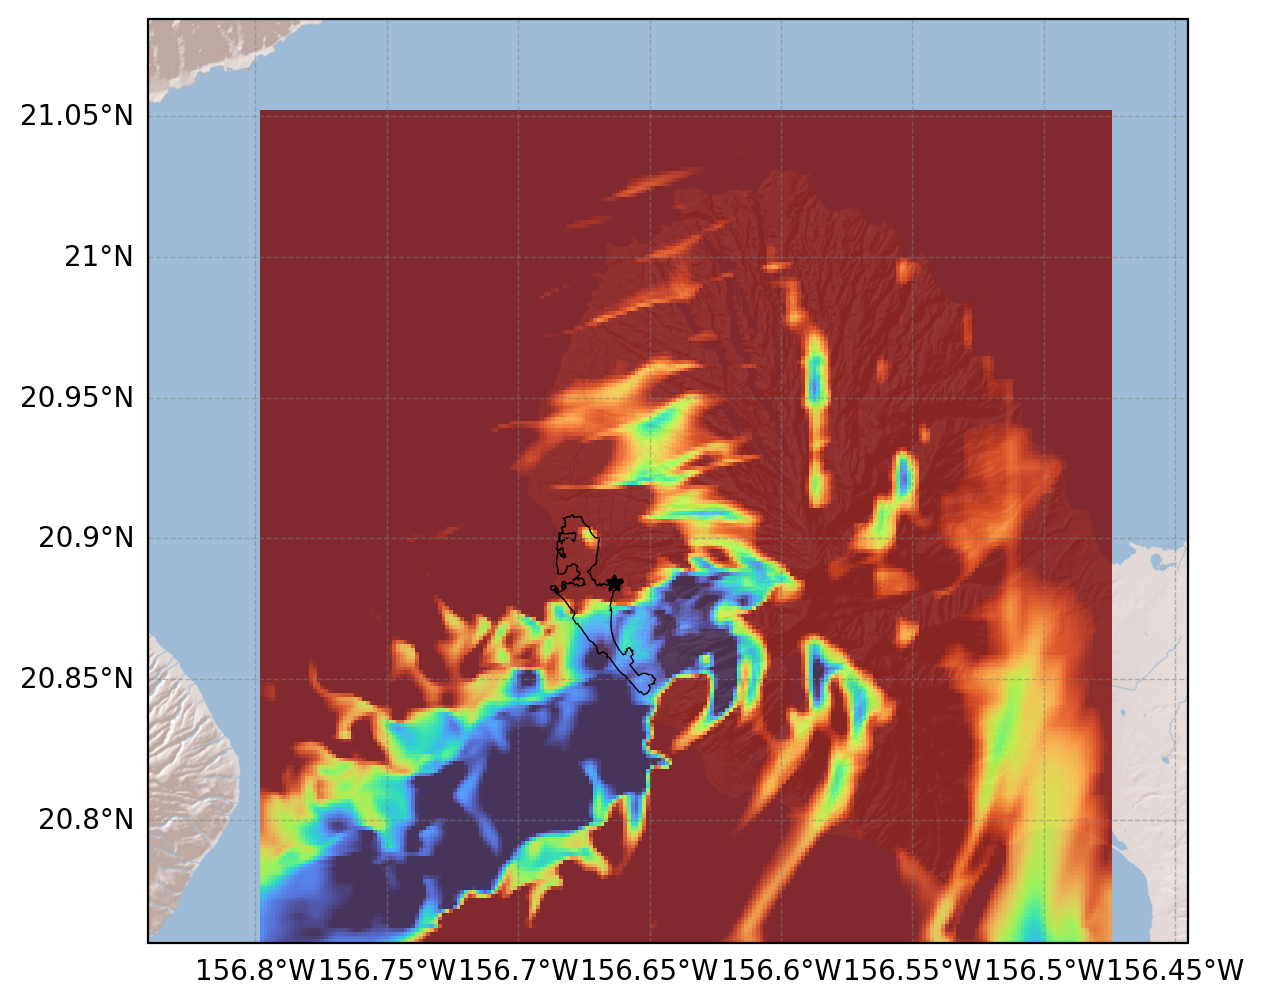

In [15]:
# Create a figure
fig = plt.figure(figsize=(12,6))

# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=ShadedReliefESRI().crs)
# ax.set_extent([-156.72,-156.62, 20.83, 20.93])
ax.add_image(ShadedReliefESRI(), 13)

# ax = plt.axes(projection=crs.PlateCarree())
plt.pcolormesh(xlons, xlats, u, cmap='turbo_r', transform=crs.PlateCarree(), vmin=-5, vmax=5, alpha=0.8)

ax = plt.gca()
ax.add_geometries(polygons, crs=crs.PlateCarree(), edgecolor='black', alpha=1, facecolor='none', linewidth=0.5)


ax.plot(-156.663453,20.884069, marker="*", color="black", transform=crs.PlateCarree())
# plt.colorbar(label='hours since ignition')
# plt.title('LAHAINA FIRE PROGRESSION')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
# plt.savefig(fig_path + 'fire_progression_fsri_18Z07.png', dpi=300)